<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Asssignment%2011/Face_verifiers_in_BCE_AND_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Constructive Loss

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split

# Download LFW dataset
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Dataset path:", path)

MAX_IMAGES = 2000  # Load only 1000 images

def load_lfw_dataset(dataset_path, max_images=MAX_IMAGES):
    images = []
    labels = []
    label_dict = {}
    current_label = 0
    count = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                if count >= max_images:
                    break
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (128, 128)) / 255.0

                    person_name = os.path.basename(root)
                    if person_name not in label_dict:
                        label_dict[person_name] = current_label
                        current_label += 1

                    images.append(img)
                    labels.append(label_dict[person_name])
                    count += 1
        if count >= max_images:
            break

    return np.array(images), np.array(labels)

# Load dataset
X, y = load_lfw_dataset("/kaggle/input/lfw-dataset")
print("Loaded images:", X.shape, "Labels:", y.shape)


Dataset path: /kaggle/input/lfw-dataset
Loaded images: (2000, 128, 128, 3) Labels: (2000,)


In [7]:
x_tem, x_test, y_tem, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_tem, y_tem, test_size=0.2, random_state=42)

In [8]:
import numpy as np
import random
from collections import defaultdict

def make_pairs(x, y):
    x = np.array(x)
    y = np.array(y)

    # Build dictionary: label -> list of indices
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(y):
        label_to_indices[label].append(idx)

    # Filter out labels with less than 2 samples (cannot form pairs)
    label_to_indices = {label: idxs for label, idxs in label_to_indices.items() if len(idxs) > 1}
    valid_labels = list(label_to_indices.keys())
    if len(valid_labels) < 2:
        raise ValueError("Not enough valid classes to make pairs. Need at least 2 classes with >=2 samples.")

    pairs = []
    labels_out = []

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]

        if label1 not in label_to_indices:
            continue  # skip if not enough samples to make a pair

        # ➤ Positive pair (same class)
        idx2 = idx1
        while idx2 == idx1:
            idx2 = random.choice(label_to_indices[label1])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels_out.append(0)

        # ➤ Negative pair (different class)
        labCel2 = label1
        while label2 == label1 or label2 not in label_to_indices:
            label2 = random.choice(valid_labels)
        idx2 = random.choice(label_to_indices[label2])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels_out.append(1)

    return np.array(pairs), np.array(labels_out).astype("float32")

# Generate data
x_train, y_train = make_pairs(x_train, y_train)
x_val, y_val = make_pairs(x_val, y_val)
x_test, y_test = make_pairs(x_test, y_test)

print("Train pairs:", x_train.shape, y_train.shape, "Val pairs:", x_val.shape, y_val.shape, "Test pairs:", x_test.shape, y_test.shape)

Train pairs: (1932, 2, 128, 128, 3) (1932,) Val pairs: (352, 2, 128, 128, 3) (352,) Test pairs: (186, 2, 128, 128, 3) (186,)


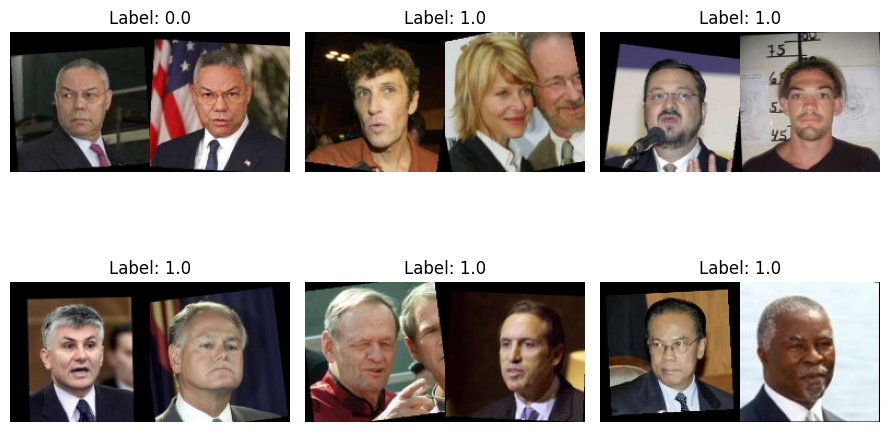

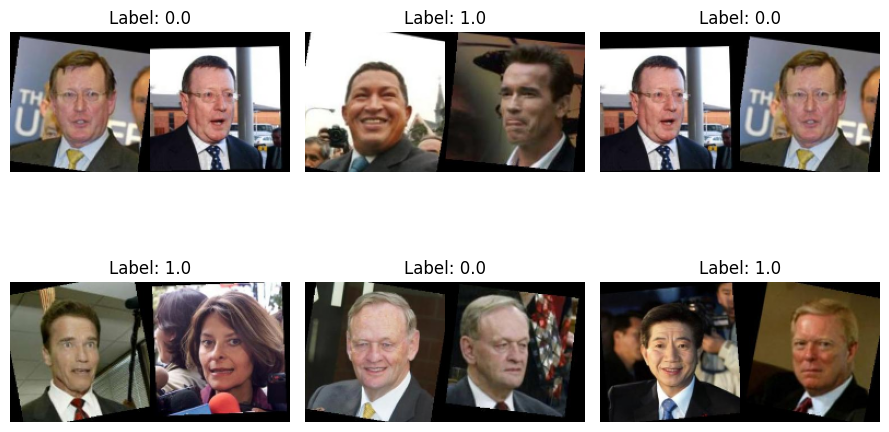

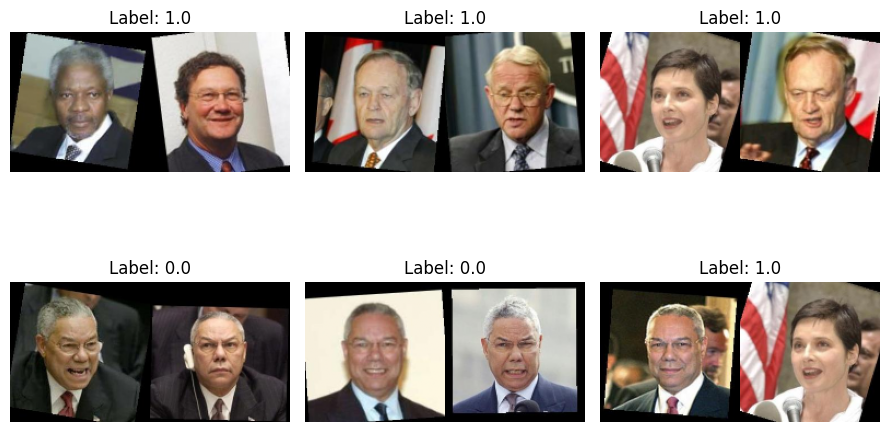

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_pairs(pairs, labels, to_show=6, num_col=3, predictions=None, test=False, seed=None):
    """
    Visualize image pairs side by side with optional predictions.

    Args:
        pairs (array-like): List or array of (img1, img2) tuples.
        labels (array-like): Corresponding labels (0 or 1).
        to_show (int): Number of image pairs to display.
        num_col (int): Number of columns in the grid.
        predictions (array-like): Model predictions to optionally show.
        test (bool): Whether to show predicted values.
        seed (int): Optional seed for reproducible randomness.
    """
    if seed is not None:
        random.seed(seed)

    to_show = min(to_show, len(pairs))
    selected_indices = random.sample(range(len(pairs)), to_show)
    num_row = (to_show + num_col - 1) // num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))
    axes = np.array(axes).reshape(-1)  # Flatten in case of single row

    for i, idx in enumerate(selected_indices):
        img1, img2 = pairs[idx][0], pairs[idx][1] # Access the individual images
        pair_image = np.concatenate([img1, img2], axis=1)
        axes[i].imshow(pair_image)
        axes[i].axis("off")
        if test and predictions is not None:
            axes[i].set_title(f"True: {labels[idx]} | Pred: {predictions[idx][0]:.2f}")
        else:
            axes[i].set_title(f"Label: {labels[idx]}")

    # Hide unused axes if total < grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage (image pairs should be tuples/lists of (img1, img2)):
# If you use single images (like in classification), wrap them as (img, img)
# Wrapped calls are not needed, pass the original pairs data
visualize_pairs(x_train, y_train, to_show=6, num_col=3)
visualize_pairs(x_val, y_val, to_show=6, num_col=3)
visualize_pairs(x_test, y_test, to_show=6, num_col=3)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np

# ------------------------------------------
# Utility: Euclidean Distance Layer
# ------------------------------------------
def euclidean_distance(vectors):
    x, y = vectors
    return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True), K.epsilon()))

# ------------------------------------------
# Contrastive Loss Function
# ------------------------------------------
def contrastive_loss_fn(margin=1.0):
    def loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)
    return loss

# ------------------------------------------
# Embedding Network (shared CNN)
# ------------------------------------------
def create_embedding_network(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2D(4, (5, 5), activation='tanh')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Conv2D(16, (5, 5), activation='tanh')(x)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(10, activation='tanh')(x)
    return models.Model(inputs, x, name="EmbeddingNetwork")

# ------------------------------------------
# Siamese Network Model
# ------------------------------------------
def build_siamese_model(input_shape=(128, 128, 3), margin=1.0):
    embedding_model = create_embedding_network(input_shape)

    input_a = layers.Input(shape=input_shape, name="input_1")
    input_b = layers.Input(shape=input_shape, name="input_2")

    embedding_a = embedding_model(input_a)
    embedding_b = embedding_model(input_b)

    distance = layers.Lambda(euclidean_distance, name="euclidean_distance")([embedding_a, embedding_b])
    norm_distance = layers.BatchNormalization()(distance)
    output = layers.Dense(1, activation='sigmoid')(norm_distance)

    model = models.Model(inputs=[input_a, input_b], outputs=output, name="SiameseNetwork")
    model.compile(optimizer='RMSprop', loss=contrastive_loss_fn(margin), metrics=['accuracy'])

    return model

# ------------------------------------------
# Model Summary
# ------------------------------------------
siamese_model = build_siamese_model(margin=1.0)
siamese_model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingNetwork    │ (None, 10)        │    190,326 │ input_1[0][0],    │
│ (Functional)        │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ euclidean_distance  │ (None, 1)         │          0 │ EmbeddingNetwork… │
│ (Lambda)            │                   │            │ EmbeddingNetwork… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ euclidean_distan… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 190,332 (743.48 KB)

 Trainable params: 163,412 (638.33 KB)

 Non-trainable params: 26,920 (105.16 KB)

In [13]:
x_train_1 = x_train[:, 0]
x_train_2 = x_train[:, 1]
x_val_1 = x_val[:, 0]
x_val_2 = x_val[:, 1]
x_test_1 = x_test[:, 0]
x_test_2 = x_test[:, 1]

In [15]:
history = siamese_model.fit(
    [x_train_1, x_train_2],
    y_train,
    validation_data=([x_val_1, x_val_2], y_val),
    batch_size=32,
    epochs=20,
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.5646 - loss: 0.2484 - val_accuracy: 0.5085 - val_loss: 0.2480
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6131 - loss: 0.2437 - val_accuracy: 0.5540 - val_loss: 0.2438
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6123 - loss: 0.2394 - val_accuracy: 0.5114 - val_loss: 0.2521
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5920 - loss: 0.2433 - val_accuracy: 0.5653 - val_loss: 0.2414
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6310 - loss: 0.2386 - val_accuracy: 0.5938 - val_loss: 0.2349
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6182 - loss: 0.2354 - val_accuracy: 0.5682 - val_loss: 0.2434
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6334 - loss: 0.2337 - val_accuracy: 0.6080 - val_loss: 0.2336
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6325 - loss: 0.2286 - val_accuracy: 0.5938 - 

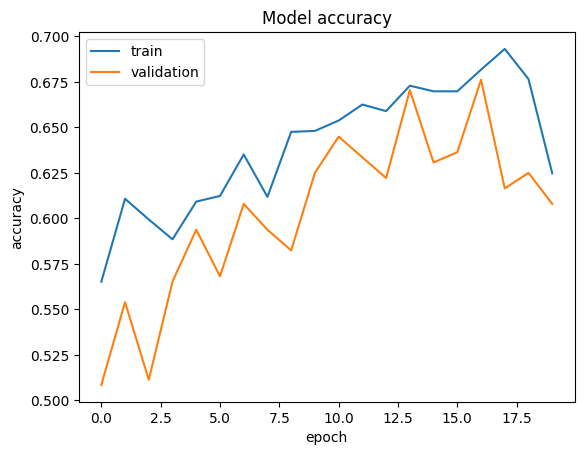

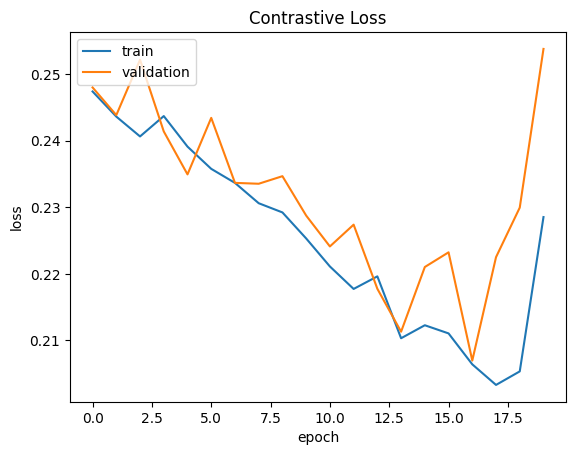

In [17]:
def plt_metric(history, metric, title, has_valid=True):

    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [19]:
results = siamese_model.evaluate([x_test_1, x_test_2], y_test)
print("test loss, test acc:", results)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6170 - loss: 0.2303
test loss, test acc: [0.22983257472515106, 0.6236559152603149]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


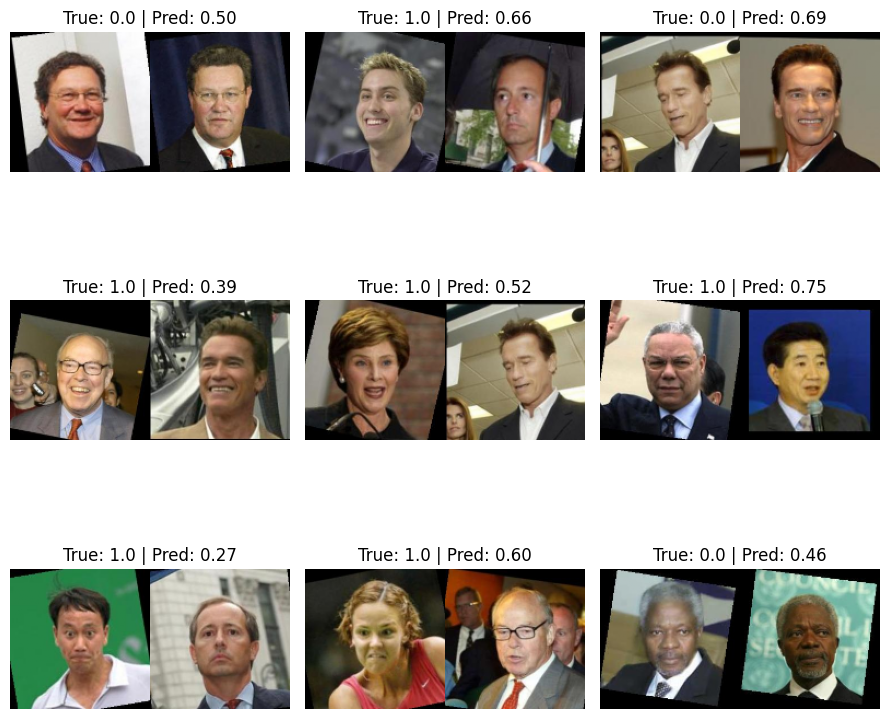

In [22]:
predictions = siamese_model.predict([x_test_1, x_test_2])
visualize_pairs(x_test, y_test, to_show=9, predictions=predictions, test=True)

#Triplet Loss

In [23]:
import tensorflow as tf
import numpy as np
import random
from pathlib import Path

# ---------------------------------------
# Configuration
# ---------------------------------------
DATA_DIR = Path("/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled")
IMAGE_SIZE = (200, 200)
NUM_TRIPLETS = 5000
BATCH_SIZE = 32
TRAIN_SPLIT = 0.8

# ---------------------------------------
# Image Preprocessing
# ---------------------------------------
def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1]
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def preprocess_triplet(anchor, positive, negative):
    return (
        load_and_preprocess_image(anchor),
        load_and_preprocess_image(positive),
        load_and_preprocess_image(negative)
    )

# ---------------------------------------
# Identity and Triplet Sampling
# ---------------------------------------
def get_eligible_identities(min_images=2):
    return [
        person for person in DATA_DIR.iterdir()
        if len(list(person.glob("*.jpg"))) >= min_images
    ]

def generate_triplet_paths(identities, count=NUM_TRIPLETS):
    anchors, positives, negatives = [], [], []

    while len(anchors) < count:
        pos_id = random.choice(identities)
        neg_id = random.choice(identities)
        if neg_id == pos_id:
            continue

        pos_images = list(pos_id.glob("*.jpg"))
        neg_images = list(neg_id.glob("*.jpg"))

        if len(pos_images) < 2 or not neg_images:
            continue

        a, p = random.sample(pos_images, 2)
        n = random.choice(neg_images)

        anchors.append(str(a))
        positives.append(str(p))
        negatives.append(str(n))

    return anchors, positives, negatives

# ---------------------------------------
# Build tf.data Dataset
# ---------------------------------------
def create_triplet_dataset(anchor_paths, positive_paths, negative_paths):
    anchor_ds = tf.data.Dataset.from_tensor_slices(anchor_paths)
    positive_ds = tf.data.Dataset.from_tensor_slices(positive_paths)
    negative_ds = tf.data.Dataset.from_tensor_slices(negative_paths)

    triplets = tf.data.Dataset.zip((anchor_ds, positive_ds, negative_ds))
    triplets = triplets.map(preprocess_triplet, num_parallel_calls=tf.data.AUTOTUNE)

    return triplets

# ---------------------------------------
# Prepare Training and Validation Datasets
# ---------------------------------------
def prepare_datasets():
    identities = get_eligible_identities()
    a_paths, p_paths, n_paths = generate_triplet_paths(identities, count=NUM_TRIPLETS)

    full_dataset = create_triplet_dataset(a_paths, p_paths, n_paths)

    train_size = int(TRAIN_SPLIT * NUM_TRIPLETS)
    train_ds = full_dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_ds = full_dataset.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

# ---------------------------------------
# Execution
# ---------------------------------------
train_dataset, val_dataset = prepare_datasets()


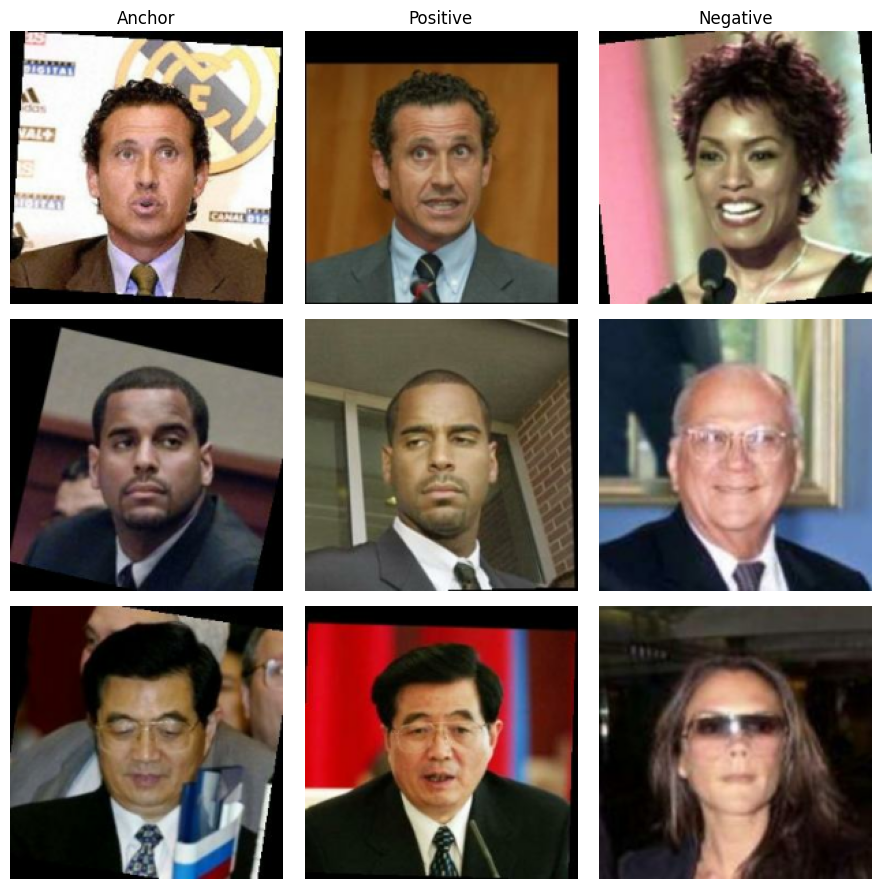

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_triplets(anchor_batch, positive_batch, negative_batch, num_triplets=3, indices=None):
    """
    Visualize triplets (anchor, positive, negative) images side-by-side.

    Args:
        anchor_batch (array-like): Batch of anchor images.
        positive_batch (array-like): Batch of positive images.
        negative_batch (array-like): Batch of negative images.
        num_triplets (int): Number of triplets to display (default 3).
        indices (list or array): Optional list of indices to visualize.
                                If None, random indices will be chosen.
    """
    batch_size = len(anchor_batch)
    num_triplets = min(num_triplets, batch_size)

    if indices is None:
        indices = np.random.choice(batch_size, size=num_triplets, replace=False)
    else:
        # Make sure indices is an iterable and valid
        indices = np.array(indices)[:num_triplets]

    fig, axes = plt.subplots(num_triplets, 3, figsize=(9, 3 * num_triplets))
    if num_triplets == 1:
        axes = axes.reshape(1, -1)  # Handle single row

    for i, idx in enumerate(indices):
        for j, image in enumerate([anchor_batch[idx], positive_batch[idx], negative_batch[idx]]):
            ax = axes[i, j]
            ax.imshow(image)
            ax.axis('off')
            if i == 0:  # Set titles only for first row
                if j == 0:
                    ax.set_title('Anchor')
                elif j == 1:
                    ax.set_title('Positive')
                else:
                    ax.set_title('Negative')

    plt.tight_layout()
    plt.show()

# Usage example with random indices:
batch = next(iter(train_dataset))
visualize_triplets(*batch, num_triplets=3)

# Usage example with specific indices:
# visualize_triplets(*batch, num_triplets=3, indices=[5, 10, 20])


In [28]:
from tensorflow.keras.applications import resnet
from tensorflow.keras import layers, Model

# Define input shape
input_shape = IMAGE_SIZE + (3,)  # e.g. (200, 200, 3)

# Load ResNet50 backbone, exclude top classification layers
base_cnn = resnet.ResNet50(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False
)

# Add custom layers on top of ResNet50 output
x = layers.Flatten()(base_cnn.output)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(256)(x)  # Final embedding layer without activation

# Create embedding model
embedding = Model(inputs=base_cnn.input, outputs=output, name="Embedding")

# Freeze all layers except those from 'conv5_block1_out' onwards
trainable_flag = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable_flag = True
    layer.trainable = trainable_flag

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [31]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics
from tensorflow.keras.applications import resnet

# Assuming target_shape and embedding model are defined
# target_shape = (200, 200) # This is defined as IMAGE_SIZE
# embedding = your_embedding_model_here # This is defined as embedding

class DistanceLayer(layers.Layer):
    """
    Computes squared L2 distances between embeddings:
      - anchor to positive
      - anchor to negative
    """

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return ap_distance, an_distance


# Inputs
anchor_input = layers.Input(name="anchor", shape=IMAGE_SIZE + (3,))
positive_input = layers.Input(name="positive", shape=IMAGE_SIZE + (3,))
negative_input = layers.Input(name="negative", shape=IMAGE_SIZE + (3,))

# Preprocess inputs and get embeddings
anchor_emb = embedding(resnet.preprocess_input(anchor_input))
positive_emb = embedding(resnet.preprocess_input(positive_input))
negative_emb = embedding(resnet.preprocess_input(negative_input))

# Compute distances
distances = DistanceLayer()(
    anchor_emb,
    positive_emb,
    negative_emb,
)

# Siamese model outputting distances
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances,
    name="SiameseNetwork"
)


class SiameseModel(Model):
    """
    Custom Siamese model with triplet loss training.
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        # Unpack the tuple of tensors into a list
        anchor, positive, negative = inputs
        return self.siamese_network([anchor, positive, negative])

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Unpack the tuple of tensors into a list before calling the network
        ap_distance, an_distance = self.siamese_network(list(data))
        loss = ap_distance - an_distance + self.margin
        loss = tf.maximum(loss, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [33]:
from tensorflow.keras import optimizers

siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
history=siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 96s 512ms/step - loss: 0.3487 - val_loss: 0.3071
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 398ms/step - loss: 0.2562 - val_loss: 0.2768
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 445ms/step - loss: 0.2011 - val_loss: 0.2709
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - loss: 0.1660 - val_loss: 0.2613
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 399ms/step - loss: 0.1428 - val_loss: 0.2597
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 401ms/step - loss: 0.1186 - val_loss: 0.2530
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 403ms/step - loss: 0.0990 - val_loss: 0.2854
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - loss: 0.0948 - val_loss: 0.2768
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 402ms/step - loss: 0.0768 - val_loss: 0.2676
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 400ms/step - loss: 0.0584 - val_loss: 0.2730
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 399ms/step - loss: 0.0469 - val_loss: 0.3070
Epoch 12/20
125/125

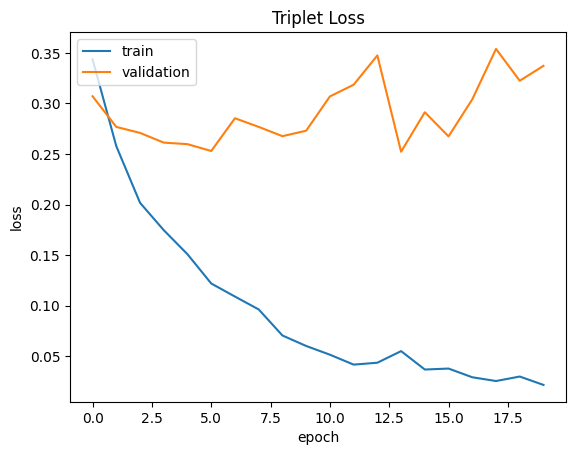

In [34]:
# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Triplet Loss")

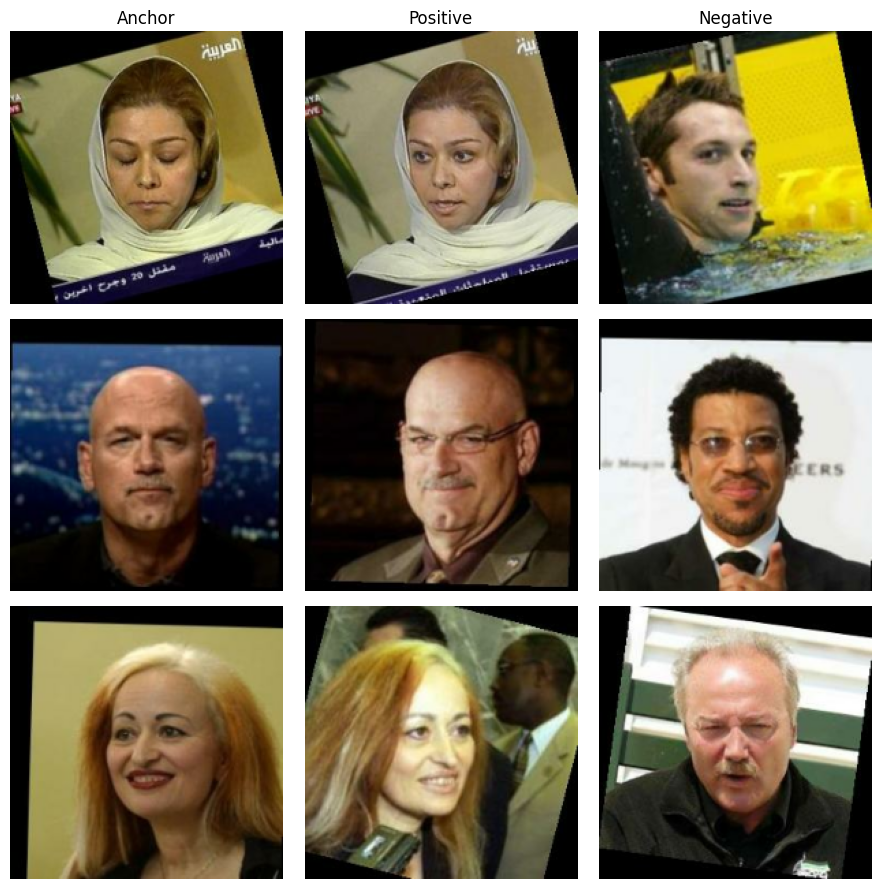

Average Cosine Similarity (Anchor vs Positive): 0.9993
Average Cosine Similarity (Anchor vs Negative): 0.9989


In [37]:
# Get one batch of triplets
sample = next(iter(train_dataset))

# Visualize the first few triplets
visualize_triplets(*sample)

# Unpack the batch
anchor, positive, negative = sample

# Compute embeddings (with ImageNet preprocessing)
anchor_emb = embedding(resnet.preprocess_input(anchor))
positive_emb = embedding(resnet.preprocess_input(positive))
negative_emb = embedding(resnet.preprocess_input(negative))

# Define cosine similarity metric
cos_sim = metrics.CosineSimilarity(axis=-1) # Specify axis for cosine similarity

# Compute average cosine similarity for anchor-positive and anchor-negative
pos_sim = cos_sim(anchor_emb, positive_emb).numpy()
neg_sim = cos_sim(anchor_emb, negative_emb).numpy()

# Output results
print(f"Average Cosine Similarity (Anchor vs Positive): {pos_sim:.4f}")
print(f"Average Cosine Similarity (Anchor vs Negative): {neg_sim:.4f}")

#Binary Cross Entropy

In [39]:
# Define the Siamese network for binary classification
def build_siamese_binary_model(input_shape=(128, 128, 3)):
    embedding_model = create_embedding_network(input_shape) # Reuse the embedding network from Contrastive Loss part

    input_a = layers.Input(shape=input_shape, name="input_1")
    input_b = layers.Input(shape=input_shape, name="input_2")

    embedding_a = embedding_model(input_a)
    embedding_b = embedding_model(input_b)

    distance = layers.Lambda(euclidean_distance, name="euclidean_distance")([embedding_a, embedding_b])
    norm_distance = layers.BatchNormalization()(distance)
    # Add a dense layer with sigmoid activation for binary classification
    output = layers.Dense(1, activation='sigmoid', name="binary_output")(norm_distance)

    model = models.Model(inputs=[input_a, input_b], outputs=output, name="SiameseBinaryNetwork")

    return model

# Build the model
siamese_binary = build_siamese_binary_model()
siamese_binary.summary()

Model: "SiameseBinaryNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingNetwork    │ (None, 10)        │    190,326 │ input_1[0][0],    │
│ (Functional)        │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ euclidean_distance  │ (None, 1)         │          0 │ EmbeddingNetwork… │
│ (Lambda)            │                   │            │ EmbeddingNetwork… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ euclidean_distan… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_output       │ (None, 1)         │          2 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 190,332 (743.48 KB)

 Trainable params: 163,412 (638.33 KB)

 Non-trainable params: 26,920 (105.16 KB)

In [40]:
from tensorflow.keras import optimizers

# Compile the Siamese model
siamese_binary.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Train the model using pairs of images
history = siamese_binary.fit(
    x=[x_train_1, x_train_2],   # Two input branches
    y=y_train,                  # 0 or 1 labels (same/different)
    validation_data=([x_val_1, x_val_2], y_val),
    batch_size=32,
    epochs=20
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.4780 - loss: 1.0072 - val_accuracy: 0.5170 - val_loss: 0.8472
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5465 - loss: 0.8467 - val_accuracy: 0.4631 - val_loss: 0.8680
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6147 - loss: 0.7367 - val_accuracy: 0.4403 - val_loss: 0.9351
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6451 - loss: 0.6779 - val_accuracy: 0.4432 - val_loss: 0.9501
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7085 - loss: 0.5669 - val_accuracy: 0.4943 - val_loss: 0.9300
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7381 - loss: 0.5306 - val_accuracy: 0.4659 - val_loss: 0.9443
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7794 - loss: 0.4830 - val_accuracy: 0.4631 - val_loss: 0.9291
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8311 - loss: 0.4228 - val_accuracy: 0.4773 - 

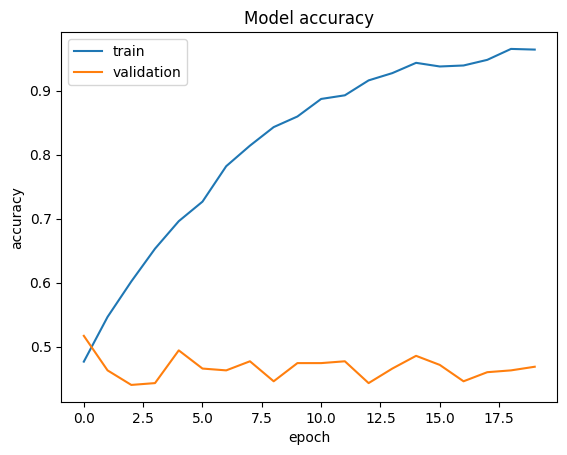

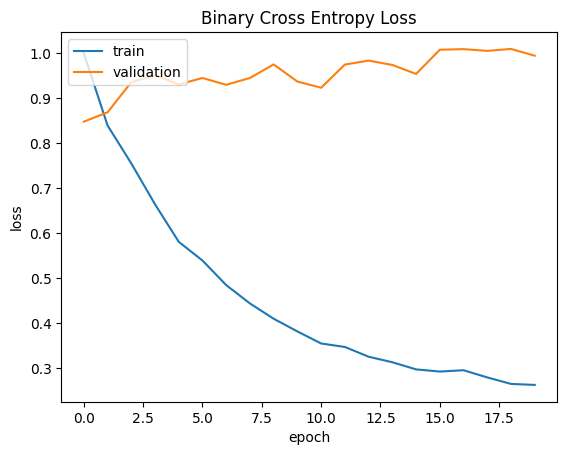

In [41]:
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Binary Cross Entropy Loss")

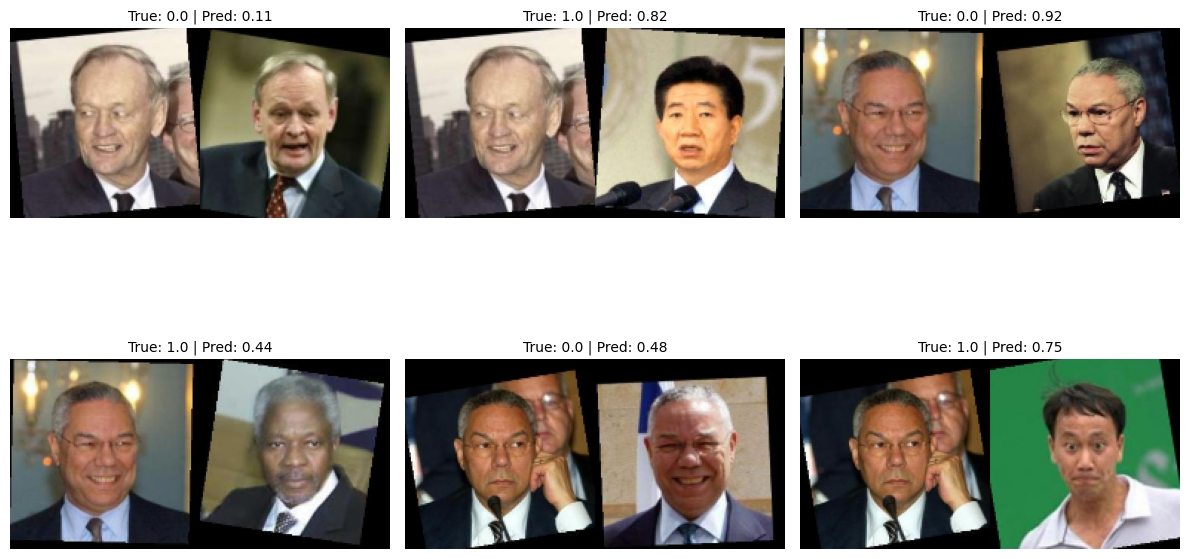

In [47]:
import matplotlib.pyplot as plt

def show_prediction_grid(pairs_x1, pairs_x2, labels, probs, num_pairs=6, cols=3):
    """
    Visualizes image pairs in a 2-row, 3-column grid (6 pairs).
    Each pair shows anchor and partner image side-by-side with prediction info.
    """
    rows = (num_pairs + cols - 1) // cols  # Ceiling division
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for i in range(num_pairs):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]

        # Concatenate anchor and pair horizontally
        image_pair = np.concatenate([pairs_x1[i], pairs_x2[i]], axis=1)
        ax.imshow(image_pair)
        ax.axis("off")
        ax.set_title(f"True: {labels[i]} | Pred: {probs[i][0]:.2f}", fontsize=10)

    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# Display 6 test pairs in 2 rows × 3 columns
# ------------------------------------------------
show_prediction_grid(x_test_1, x_test_2, y_test, probabilities, num_pairs=6, cols=3)
